In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 

In [2]:
filename = '../colliders.csv'
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('planning_utils_from_seed_project.py'))))
import planning_utils_from_seed_project
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('planning_utils.py'))))
import planning_utils
from udacidrone.frame_utils import global_to_local, local_to_global

In [4]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5
global_home = np.array([-122.39745, 37.79248, 0.0])
global_position = np.array([-122.3974512, 37.7924799, 0.147])
grid, north_offset, east_offset  = planning_utils.create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
local_position = global_to_local(global_position, global_home)
grid_start_north = int(np.ceil(local_position[0] - north_offset))
grid_start_east = int(np.ceil(local_position[1] - east_offset))
grid_start = (grid_start_north, grid_start_east)

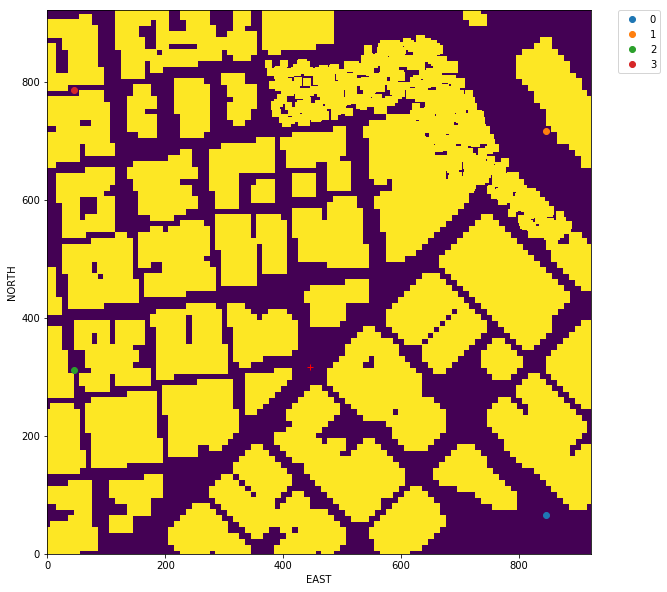

0 [-122.38784816   37.79302537   -0.147     ]
1 [-122.38779981   37.79888362   -0.147     ]
2 [-122.39691611   37.79528034   -0.147     ]
3 [-122.39688131   37.79956138   -0.147     ]


In [5]:
goals = [
    (grid_start[0] - 250, grid_start[1] + 400),
    (grid_start[0] + 400, grid_start[1] + 400),
    (grid_start[0] - 5, grid_start[1] - 400),
    (grid_start[0] + 470, grid_start[1] - 400)
]
fig = plt.figure(figsize=(20,10))   
plt.imshow(grid, origin='lower') 
plt.plot(grid_start[1], grid_start[0], 'r+')
for goal, index in zip(goals, range(4)):
    north, east = goal
    plt.plot(east, north, 'o', label=f'{index}')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
global_goals = list(map(lambda g: local_to_global(np.array([g[0], g[1], 0.147]), global_home), goals))
for g, index in zip(global_goals, range(4)):
    print(f'{index} {g}')

In [6]:
def square_a_start(g, start, goal):
    """
    A * implementation with NORTH, SOUTH, EAST, WEST
    """
    return planning_utils_from_seed_project.a_star(g, planning_utils_from_seed_project.heuristic, start, goal)

def diagonals_a_start(g, start, goal):
    """
    A * implementation with NORTH, SOUTH, EAST, WEST and diagonals
    """
    return planning_utils.a_star(g, planning_utils.heuristic, start, goal)

def prune_unity(path):
    """
    Unity function for pruning the path.
    """
    return path;

Found a path.
Found a path.
Found a path.
Found a path.


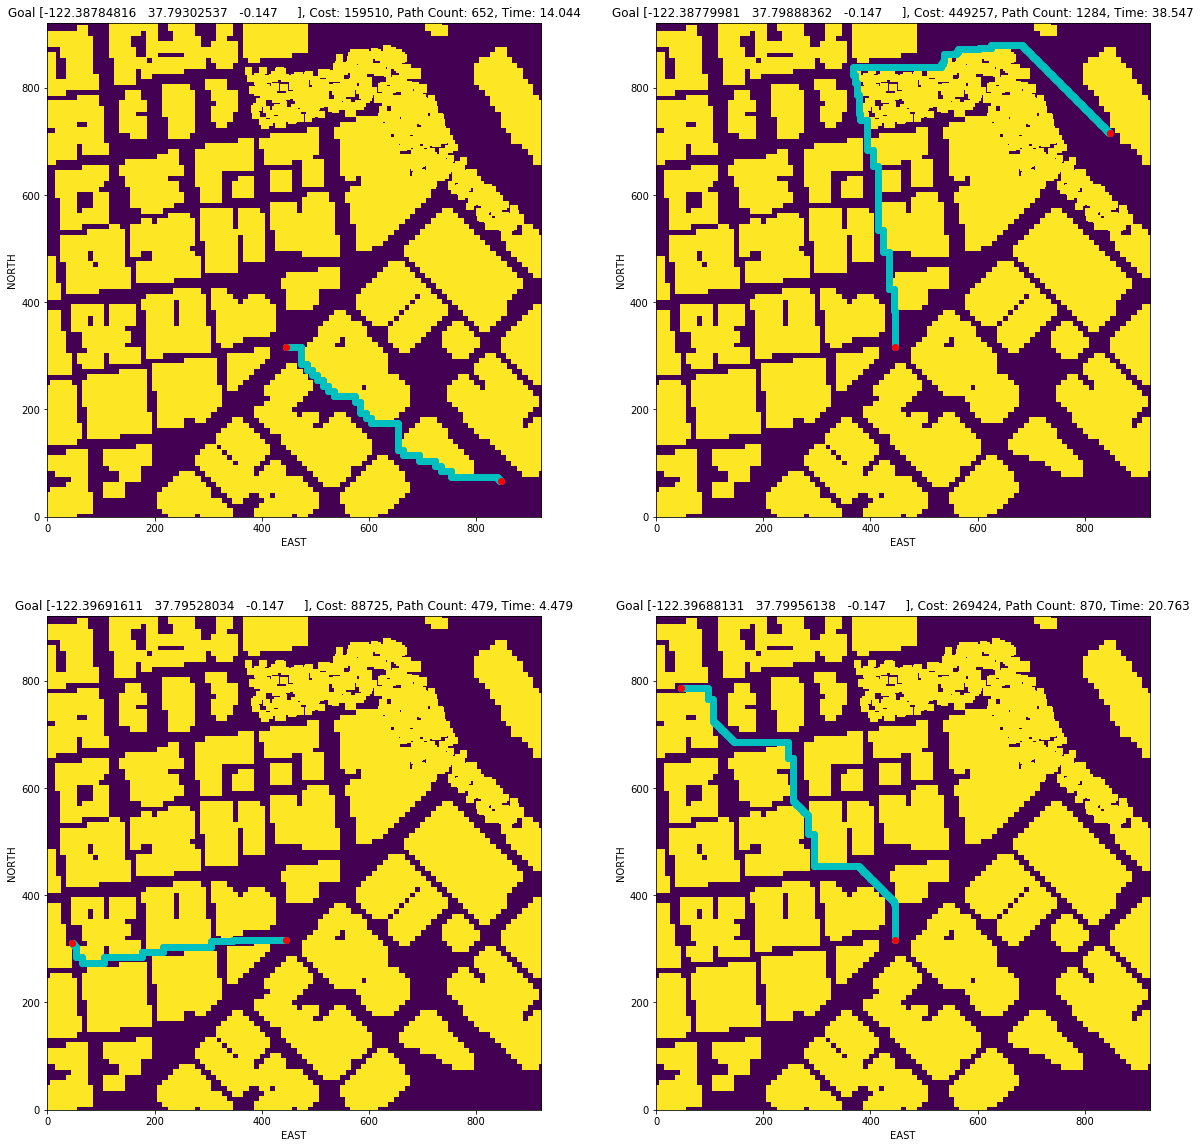

In [7]:
import time
def visualize_trajectories(g_globals, a_start_method, prune_method=prune_unity):
    """
    Visualize trajectories global goals `g_globals` using the A* function `a_start_method`
    """
    fig, axes = plt.subplots(2, 2, figsize=(20,20))
    output = []
    for ax, goal in zip(axes.flat, g_globals):
        start = time.time()
        goal_north, goal_east, _ = global_to_local(goal, global_home)
        goal_grid_north = int(np.ceil(goal_north))
        goal_grid_east = int(np.ceil(goal_east))
        goal_grid = (goal_grid_north, goal_grid_east)
        
        path, cost = a_start_method(grid, grid_start, (goal_grid_north, goal_grid_east))
        path = prune_method(path)
        end = time.time()
        time_spam = end - start
        
        waypoints = np.array([[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path])
        waypoints_count = len(path)
        
        ax.imshow(grid, origin='lower') 
        
        ax.plot(grid_start[1] + waypoints[:, 1], grid_start[0] + waypoints[:, 0], 'g')
        ax.plot(grid_start[1] + waypoints[:, 1], grid_start[0] + waypoints[:, 0], 'oc')
        
        ax.plot(grid_start[1], grid_start[0], 'ro')
        ax.plot(goal_grid[1], goal_grid[0], 'ro')
        ax.set_xlabel('EAST')
        ax.set_ylabel('NORTH')
        ax.set_title(f'Goal {goal}, Cost: {cost:5.0f}, Path Count: {waypoints_count:3.0f}, Time: {end - start:2.3f}')
        output.append((cost, waypoints_count, time_spam))
    return output
    
stats_a_start = visualize_trajectories(global_goals, square_a_start)

Found a path.
Found a path.
Found a path.
Found a path.


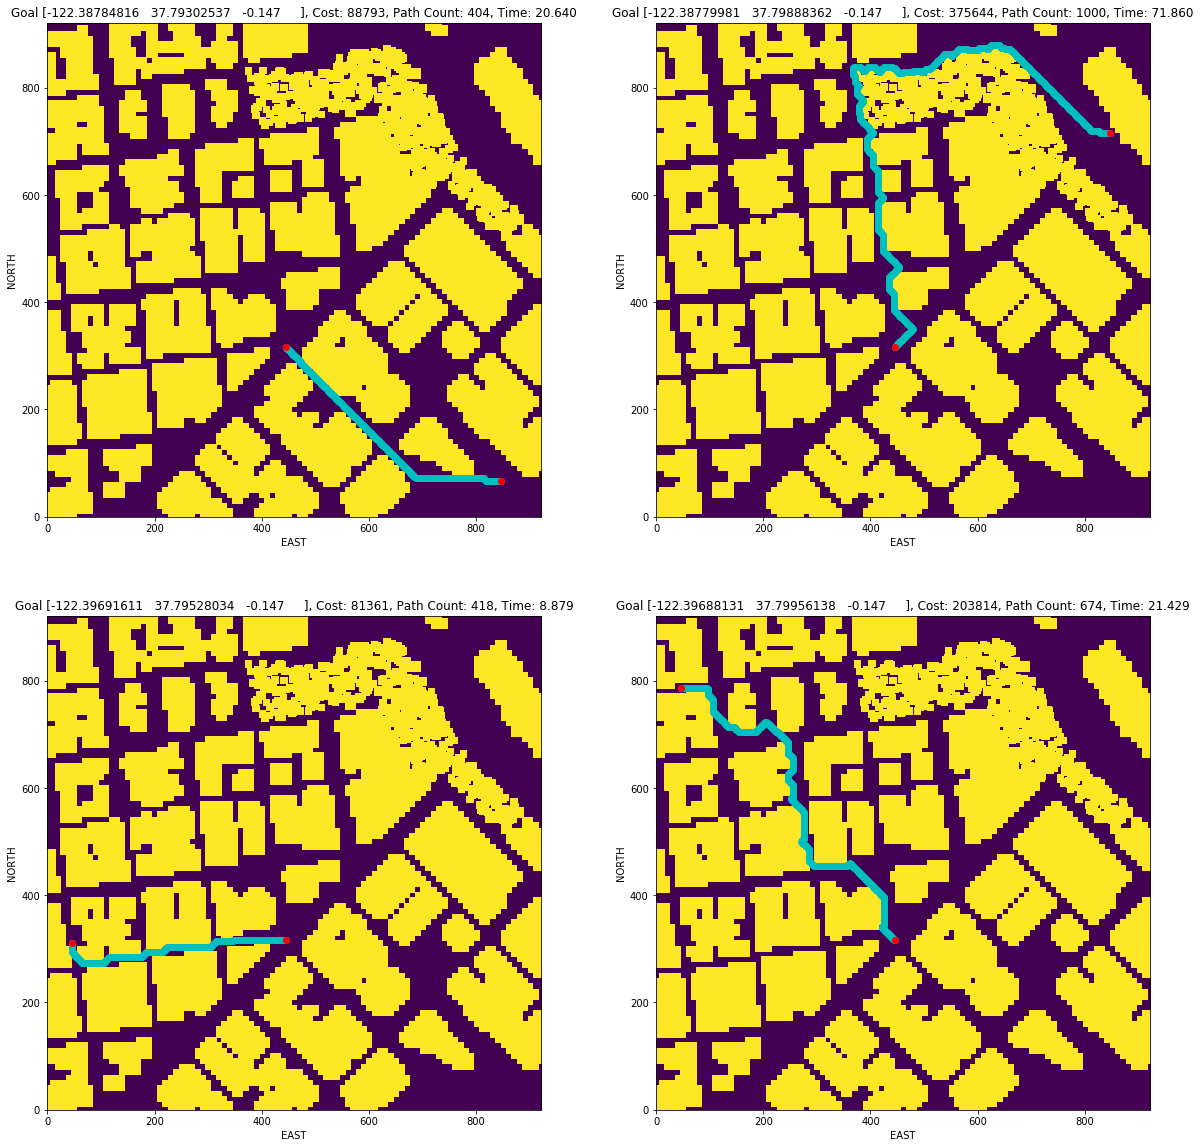

In [8]:
stats_a_start_diagonals = visualize_trajectories(global_goals, diagonals_a_start)

Found a path.
Found a path.
Found a path.
Found a path.


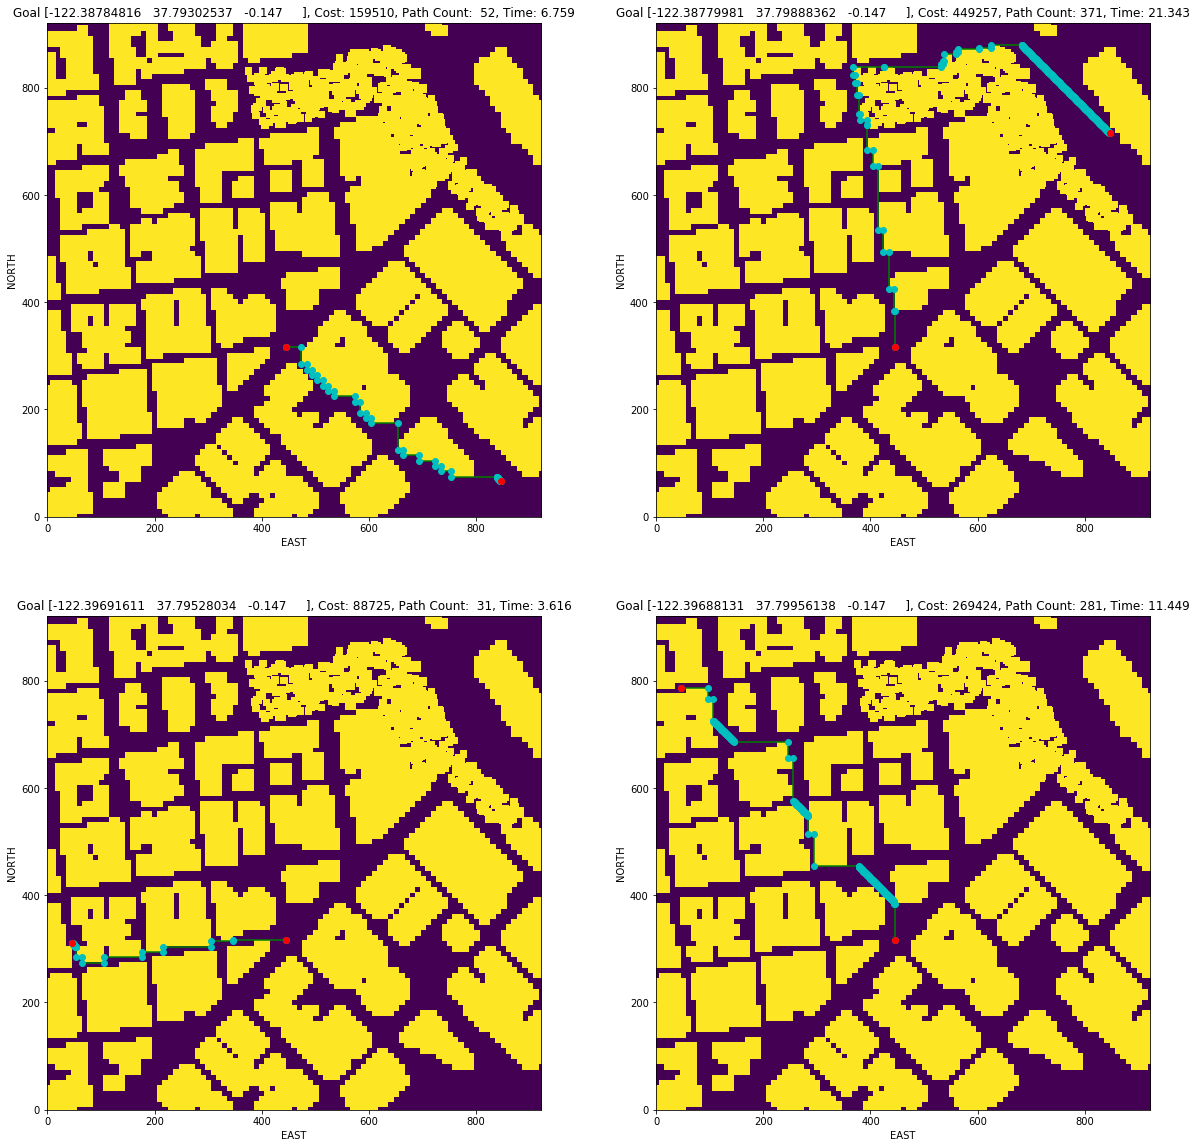

In [9]:
def collinearity_prune(path, epsilon=1e-6):
    """
    Prune path points from `path` using collinearity.
    """
    def point(p):
        return np.array([p[0], p[1], 1.]).reshape(1, -1)

    def collinearity_check(p1, p2, p3):   
        m = np.concatenate((p1, p2, p3), 0)
        det = np.linalg.det(m)
        return abs(det) < epsilon
    
    pruned_path = [p for p in path]
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

stats_a_start_coll = visualize_trajectories(global_goals, square_a_start, prune_method=collinearity_prune)

Found a path.
Found a path.
Found a path.
Found a path.


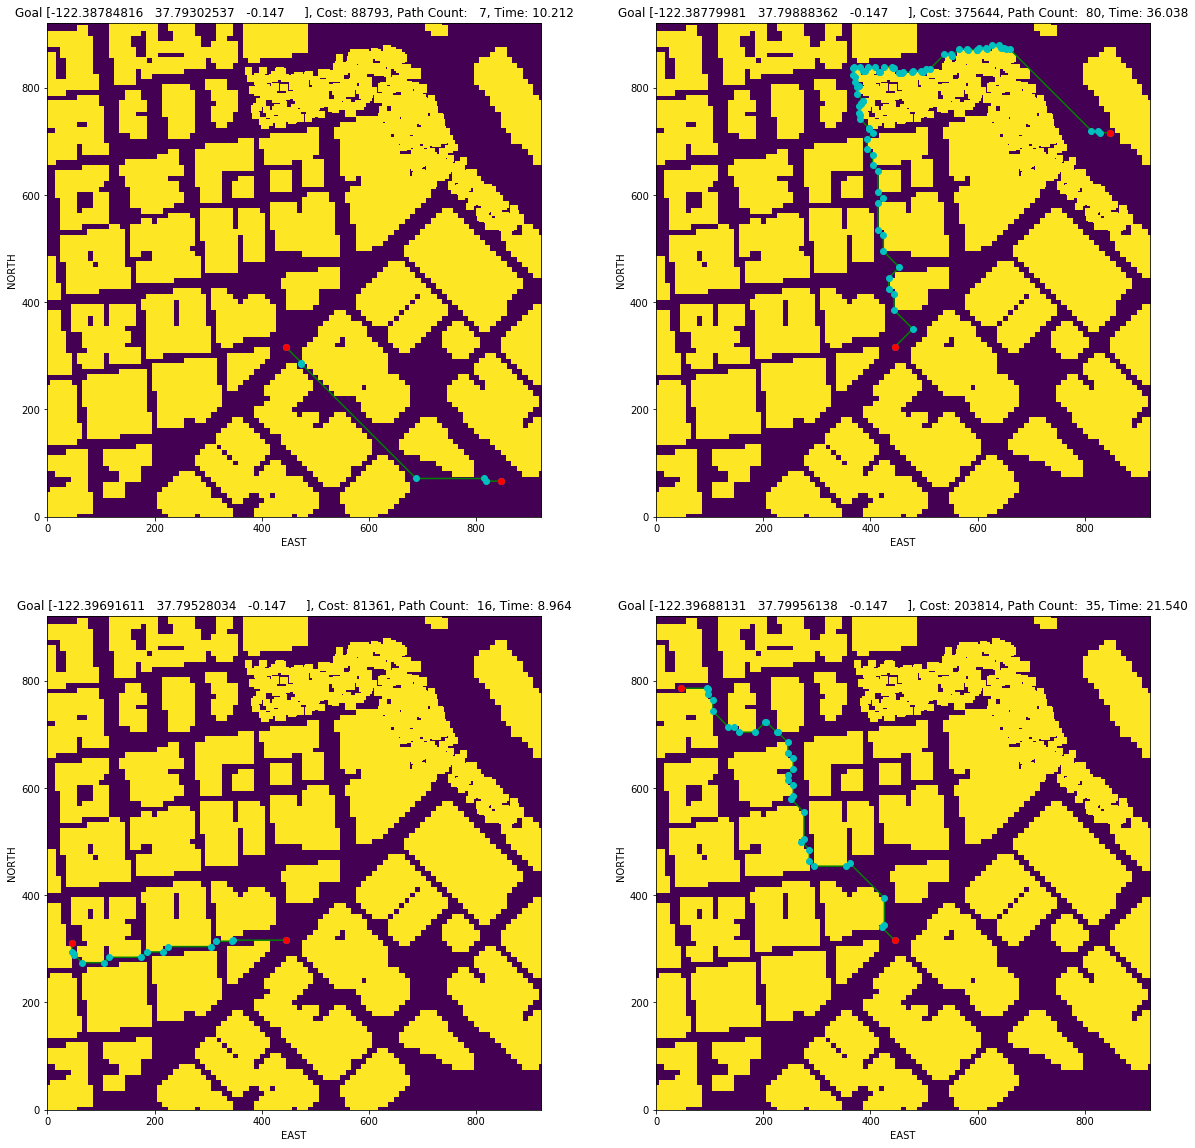

In [10]:
stats_a_start_diagonals_coll = visualize_trajectories(global_goals, diagonals_a_start, prune_method=collinearity_prune)

In [11]:
def get_stats(index):
    """
    Get stats for a index
    """
    stats = np.zeros((len(global_goals), 4), dtype='float')
    for i in range(len(global_goals)):
        stats[i, 0] = stats_a_start[i][index]
        stats[i, 1] = stats_a_start_diagonals[i][index]
        stats[i, 2] = stats_a_start_coll[i][index]
        stats[i, 3] = stats_a_start_diagonals_coll[i][index]
    return stats

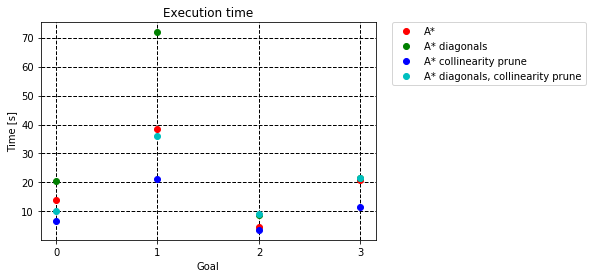

In [12]:
def plot_stats(stats, title):
    """
    Plot `stats` for with `title`
    """
    plt.plot(stats[:,0], 'ro', label='A*')
    plt.plot(stats[:,1], 'go', label='A* diagonals')
    plt.plot(stats[:,2], 'bo', label='A* collinearity prune')
    plt.plot(stats[:,3], 'co', label='A* diagonals, collinearity prune')
    plt.xlabel('Goal')
    plt.ylabel('Time [s]')
    plt.xticks(range(0,4))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(color='black', linestyle='--', linewidth=1)
    plt.title(title)
    plt.show()

plot_stats(get_stats(2), 'Execution time')

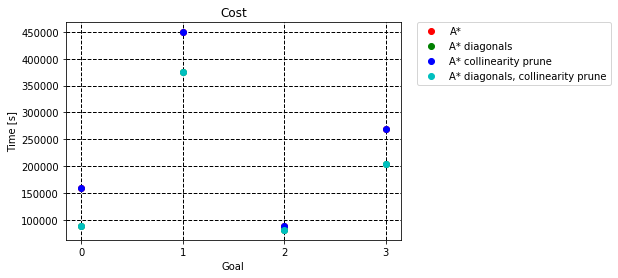

In [13]:
plot_stats(get_stats(0), 'Cost')

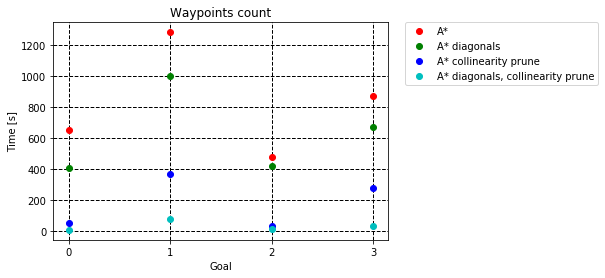

In [14]:
plot_stats(get_stats(1), 'Waypoints count')